In [4]:
#############
###paths#####
#############
import sys
import os

pwd = os.getcwd()
modellingpath = pwd.rpartition("modelling")[0] + pwd.rpartition("modelling")[1] 
sys.path.append(modellingpath + '/lib')
#############
import pickle as pkl
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from equations.class_subcircuit_eq import *
from sklearn.metrics import mean_squared_error


In [5]:
def plotDoseResponse2(inducer, doseResponseGreen, doseResponseRed,pad=0.01):
    fig,ax = plt.subplots()
    # ax.ticklabel_format(style='plain')      
    ax.plot(inducer,doseResponseGreen,label='GFP', c='green')
    # ax.set_ylim(np.amin(U[0])-pad, np.amax(U[0])+pad)
    ax.legend(loc='center left') #upper left
    ax.ticklabel_format(useOffset=False)

    ax2=ax.twinx()
    ax2.plot(inducer,doseResponseRed,label='RFP', c='red')
    # ax2.set_ylim(np.amin(U[1])-pad, np.amax(U[1])+pad)
    ax2.legend(loc='center right') #upper right

    ax2.ticklabel_format(useOffset=False)
    ax.set_xscale('log')
    plt.show()

def plotDoseResponse(inducer_list, U_ss, color='k'):
    plt.plot(inducer_list,U_ss, c=color)
    plt.xlabel('[inducer]')
    plt.ylabel('Fluorescence')
    plt.xscale('log')
    plt.show()

def doseResponse(subcircuit, inducer_list, initial_conditions=[10,10]):
    U_ss = []
    T=1000
    t = np.linspace(0, T, T*50)
    for inducer in inducer_list:
        sol = odeint(subcircuit.ddt, initial_conditions, t, args=(inducer,inducer))
        Ustar_ODE=sol[-1]
        U_ss.append(sol[-1])
    return np.array(U_ss)

In [2]:
seq = input("Enter sequence: ")
print(seq)

j


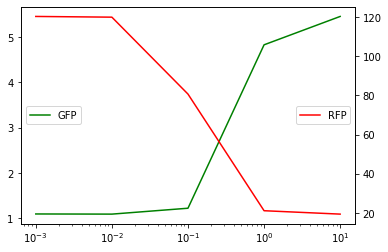

array([1.e+01, 1.e+00, 1.e-01, 1.e-02, 1.e-03])

In [6]:
doseResponseExp = pkl.load(open('input/subcircuit1_circuit14_doseResponse_maxATC.pkl','rb'))
AHL_list = doseResponseExp['AHL_list']; gfpExp_list = doseResponseExp['maxATC_doseResponse_gfp']; rfpExp_list = doseResponseExp['maxATC_doseResponse_rfp']
plotDoseResponse2(AHL_list,gfpExp_list, rfpExp_list)
AHL_list

In [34]:
class hill_functions():

    def __init__(self, par_dict):
        for key, value in par_dict.items():
            setattr(self, key, value)

    def noncompetitiveact(self, X, km,n):
        act = ((X / km) ** (n)) / (1 + (X / km) ** (n))
        act = (1 / (1 + (km / (X+1e-08)) ** (n)))
        return act

    def noncompetitiveinh(self, X, km,n):
        inh = 1 / (1 + (X / (km+1e-08)) ** (n))
        return inh


    def noncompetitivediffact(self, X, km,n, kdiff,mudiff):
        act = (1 / (1 + ((mudiff*km) / (kdiff*X)) ** (n)))
        return act
    
class subcircuit1_circuit14(hill_functions):#nodeC with inhibitions
#from circuit14

    def __init__(self,par_dict,stochasticity=0):
        for key,value in par_dict.items():
            setattr(self,key,value)
        setattr(self, 'stochasticity', stochasticity)



    def ddt(self,species_list,t, B,B1,wvn=0):
        # C,E,F = species_list
        E,F = species_list
        # dcdt= self.muLVA*(1 + self.VC - C ) 
        # dedt= self.muLVA*(1 + self.VE*self.noncompetitiveinh(C,self.Kce,self.nce)*self.noncompetitiveinh(F,self.Kfe,self.nfe)*self.noncompetitiveact(E,self.Kee,self.nee) - E ) 
        dedt= self.muLVA*(1 + self.VE*self.noncompetitiveinh(F,self.Kfe,self.nfe)*self.noncompetitiveact(E,self.Kee,self.nee) - E ) 
        dfdt= self.muLVA*(1 + self.VF*self.noncompetitiveact(B,self.Kbd,self.nbd) - F ) 
        # print(])
        # return dcdt, dedt, dfdt
        return dedt, dfdt

In [35]:
parameters, covariance = curve_fit(ddt, AHL_list, gfpExp_list, p0=[1, 5, 0.1,4])


<ipython-input-4-72ec962e34bc>:6: RuntimeWarning: overflow encountered in power
  return mu*( 1 + V * (1 / (1 + (km / (X+1e-08)) ** (n)) ))


<ipython-input-10-9c5fad055009>:6: RuntimeWarning: overflow encountered in power
  return mu*( 1 + V * (1 / (1 + (km / (X+1e-08)) ** (n)) ))


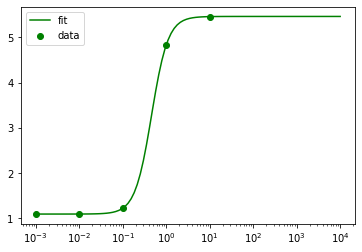

mu = 1.097, V = 3.976, km = 0.46, n = 2.291


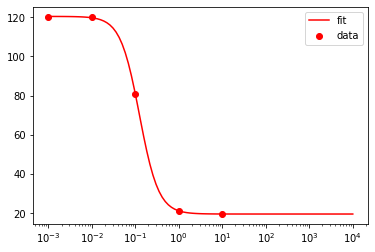

mu = 19.429, V = 5.199, km = 0.124, n = -1.976


In [10]:
from scipy.optimize import curve_fit
A_list = np.logspace(-3,4, 100)


def bioSigmoid(X,mu, V, km, n): 
     return mu*( 1 + V * (1 / (1 + (km / (X+1e-08)) ** (n)) ))

parameters, covariance = curve_fit(bioSigmoid, AHL_list, gfpExp_list, p0=[1, 5, 0.1,4])
gfpFit = bioSigmoid(A_list, *parameters)
plt.plot(A_list,gfpFit , label='fit', c='green')
plt.scatter(AHL_list,gfpExp_list , label='data', c='green')
plt.xscale('log')
plt.legend()
parameters = np.round(parameters,3)
plt.show()

print(f'mu = {parameters[0]}, V = {parameters[1]}, km = {parameters[2]}, n = {parameters[3]}')
parameters, covariance = curve_fit(bioSigmoid, AHL_list, rfpExp_list, p0=[1, 5, 0.1,-2])
rfpFit = bioSigmoid(A_list, *parameters)
plt.plot(A_list,rfpFit , label='fit', c='red')
plt.scatter(AHL_list,rfpExp_list , label='data', c='red')
plt.xscale('log')
plt.legend()
parameters = np.round(parameters,3)
plt.show()
print(f'mu = {parameters[0]}, V = {parameters[1]}, km = {parameters[2]}, n = {parameters[3]}')


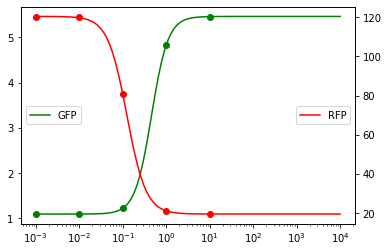

In [7]:
fig,ax = plt.subplots()
# ax.ticklabel_format(style='plain')      
ax.plot(A_list,gfpFit,label='GFP', c='green')
ax.scatter(AHL_list, gfpExp_list, c='green')
ax.legend(loc='center left') #upper left
ax.ticklabel_format(useOffset=False)

ax2=ax.twinx()
ax2.plot(A_list,rfpFit,label='RFP', c='red')
ax2.scatter(AHL_list, rfpExp_list, c='red')
ax2.legend(loc='center right') #upper right

ax2.ticklabel_format(useOffset=False)
ax.set_xscale('log')
plt.show()

# ABC Steps
Step 1: load parameter distributions (prior)\
Step 2: Sample from prior\
Step 3: Compare samples to ExpData with measure and select with threshold\
Step 4: Resample from chosen samples distribution and reduce threshold\
Step 5: 

Step 1: load parameter distributions (prior)


In [10]:

# Specify name of circuit and variant investigated
circuit_n='circuit14'
variant='0nd'
# Specifiy number of parameter sets in parameterset file to be loaded
n_param_sets = 10000

print(f'Circuit:{circuit_n}, Variant:{variant}')

df_full= pkl.load( open(modellingpath + "/3954/paper/input/balanced_parameterfiles/df_%s_variant%s_%rparametersets_balanced.pkl"%(circuit_n,variant,n_param_sets), "rb"))
df = df_full[['VE','VF','muLVA','Kbd','Kfe','nbd','nfe','Kee','nee']]
df_balanced = df_full[df_full['balance'] == 'Balanced']
df_balanced

Circuit:circuit14, Variant:0nd


,Dr,VA,VB,VC,VD,VE,VF,Kda,Kab,Keb,...,muLVA,muASV,nbd,nab,nda,nfe,nee,neb,nce,balance
39,0.410075,15.656763,644.409252,824.928170,19.763477,135.071601,70.740091,5.082314,7.606345,1.910780,...,4.234870,1.0,2.0,1.0,1.0,4.0,4.0,4.0,1.0,Balanced
55,0.471805,69.653813,56.642439,974.631017,21.053351,374.823369,12.668799,2.883573,16.723669,85.269578,...,4.567963,1.0,2.0,1.0,1.0,4.0,4.0,4.0,1.0,Balanced
110,0.185831,765.122509,414.743146,406.658784,69.856186,497.823241,422.268051,3.118004,3.356919,1.531825,...,3.210618,1.0,2.0,1.0,1.0,4.0,4.0,4.0,1.0,Balanced
163,0.744832,131.083217,666.459722,404.495202,10.665967,587.913234,137.350124,4.523439,1.993318,37.064517,...,3.642415,1.0,2.0,1.0,1.0,4.0,4.0,4.0,1.0,Balanced
219,0.263750,704.381105,258.592721,376.873275,95.178982,320.867342,141.142323,39.231940,1.599872,84.905921,...,3.507428,1.0,2.0,1.0,1.0,4.0,4.0,4.0,1.0,Balanced
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9371,4.614048,291.810615,101.856880,63.172232,734.831598,46.363624,93.468191,54.217990,96.974098,1.946989,...,3.244729,1.0,2.0,1.0,1.0,4.0,4.0,4.0,1.0,Balanced
9382,0.080771,23.659838,404.542309,33.019702,41.619058,142.424269,12.597716,3.982836,2.587030,6.792811,...,3.867815,1.0,2.0,1.0,1.0,4.0,4.0,4.0,1.0,Balanced
9629,0.153093,53.511787,25.448170,30.905811,100.375843,204.303488,33.611418,8.076404,1.586869,7.109295,...,3.400673,1.0,2.0,1.0,1.0,4.0,4.0,4.0,1.0,Balanced
9658,50.419475,61.595916,186.345482,16.448485,51.574254,263.489174,333.420829,2.954652,55.879914,1.000240,...,3.451172,1.0,2.0,1.0,1.0,4.0,4.0,4.0,1.0,Balanced


In [12]:
subcircuit = lambda x: subcircuit1_circuit14(x)

Step 2: Sample from prior


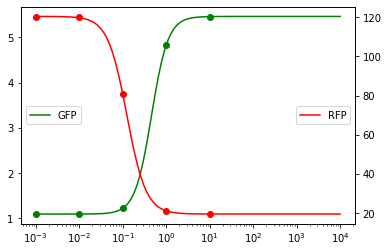

  0%|          | 0/10 [00:00<?, ?it/s]

[0.1838095884139507, 43.16163652402461]


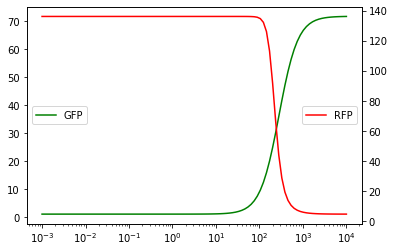

 10%|█         | 1/10 [00:00<00:06,  1.34it/s]

[0.1838095884139507, 43.16163652402461]


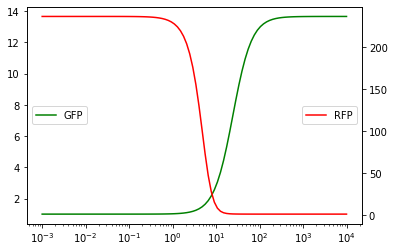

 20%|██        | 2/10 [00:01<00:06,  1.31it/s]

[0.1838095884139507, 43.16163652402461]


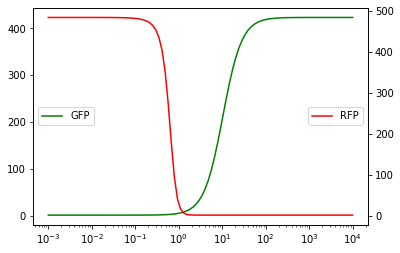

 30%|███       | 3/10 [00:02<00:05,  1.33it/s]

[0.1838095884139507, 43.16163652402461]


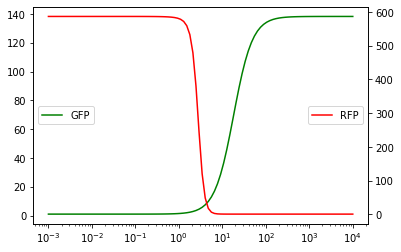

 40%|████      | 4/10 [00:03<00:04,  1.30it/s]

[0.1838095884139507, 43.16163652402461]


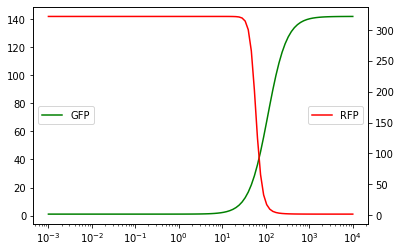

 50%|█████     | 5/10 [00:03<00:03,  1.32it/s]

[0.1838095884139507, 43.16163652402461]


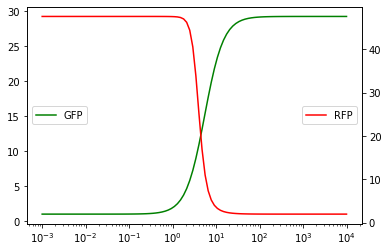

 60%|██████    | 6/10 [00:04<00:03,  1.32it/s]

[0.1838095884139507, 43.16163652402461]


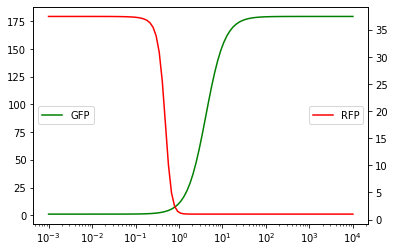

 70%|███████   | 7/10 [00:05<00:02,  1.33it/s]

[0.1838095884139507, 43.16163652402461]


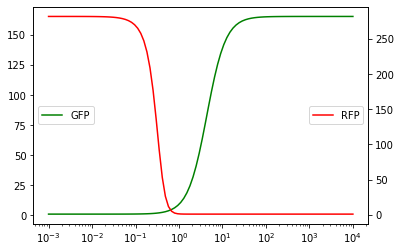

 80%|████████  | 8/10 [00:06<00:01,  1.28it/s]


KeyboardInterrupt: 

In [25]:
from tqdm import tqdm
fig,ax = plt.subplots()
# ax.ticklabel_format(style='plain')      
ax.plot(A_list,gfpFit,label='GFP', c='green')
ax.scatter(AHL_list, gfpExp_list, c='green')
ax.legend(loc='center left') #upper left
ax.ticklabel_format(useOffset=False)

ax2=ax.twinx()
ax2.plot(A_list,rfpFit,label='RFP', c='red')
ax2.scatter(AHL_list, rfpExp_list, c='red')
ax2.legend(loc='center right') #upper right

ax2.ticklabel_format(useOffset=False)
ax.set_xscale('log')
plt.show()
for parID in tqdm(df_balanced.index[:10]):
    par_dict = df.loc[parID].to_dict()
    par_dict['Kee'] = 0.1
    U_ss= doseResponse(subcircuit(par_dict), A_list)
    # plotDoseResponse2(A_list,U_ss[:,2], U_ss[:,1] )
    mse = [mean_squared_error(U_ss[:,1], gfpFit), mean_squared_error(U_ss[:,0], rfpFit)]
    mse = [mean_squared_error(gfpFit*0.9, gfpFit), mean_squared_error(rfpFit*0.9, rfpFit)]
    # print(mean_squared_error(U_ss[:,1], gfpFit), mean_squared_error(U_ss[:,0], rfpFit))
    print(mse)
    # if mse[1]<10 and mse[0]<10:
    # print(par_dict)
    # if mse<10:
    plotDoseResponse2(A_list,U_ss[:,1], U_ss[:,0] )
    # print('minmin', np.amin(U_ss[:,1]), np.amin(U_ss[:,0]))
    # print('maxmax', np.amax(U_ss[:,1]), np.amax(U_ss[:,0]))
    # print(par_dict['VF'], par_dict['VE'])
    # print('-------')
